
Test set: Avg. loss: 2.3234, Accuracy: 958/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.289047
Train Epoch: 1 [5000/60000 (8%)]	Loss: 1.178210
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.212947
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.308703
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.299044
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.316212
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.277993
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.321958
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.160333
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.227491
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.156133
Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.210604

Test set: Avg. loss: 0.1598, Accuracy: 9519/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.165410
Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.120898
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.258730
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.132670
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.119611
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.075326

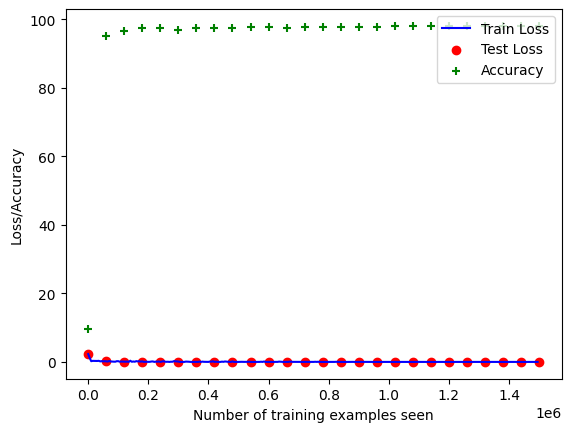

In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

class MNISTdata(Dataset):
    def __init__(self, image_data_root, label_data_root):
        # Variables for image dataset
        self.image_data_root = image_data_root
        self.num_images = 0
        self.image_rows = 0
        self.image_cols = 0
        self.images = np.empty(0)

        # Variables for label dataset
        self.label_data_root = label_data_root
        self.num_labels = 0
        self.labels = np.empty(0)

        # Initialize datasets
        self.image_init_dataset()
        self.label_init_dataset()

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        image = self.images[idx].reshape(-1).float()  # Flatten image to 1D vector and convert to float tensor
        label = self.labels[idx]
        return image, label

    def image_init_dataset(self):
        # Array of 60,000 images with dimensions 60000 x 28 x 28
        image_nparr = idx2numpy.convert_from_file(self.image_data_root)
        self.num_images = image_nparr.shape[0]
        self.image_rows = image_nparr.shape[1]
        self.image_cols = image_nparr.shape[2]
        self.images = torch.tensor(image_nparr / 255.0, dtype=torch.float32)

    def label_init_dataset(self):
        label_nparr = idx2numpy.convert_from_file(self.label_data_root)
        self.num_labels = label_nparr.shape[0]
        self.labels = torch.tensor(label_nparr, dtype=torch.long)  # Use long dtype for labels

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(784, 100)
        self.linear2 = nn.Linear(100, 50)
        self.linear3 = nn.Linear(50, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        x = self.linear3(x)
        return x

# Load datasets
training_dataset = MNISTdata("MNIST DATASET/train-images.idx3-ubyte", "MNIST DATASET/train-labels.idx1-ubyte")
testing_dataset = MNISTdata("MNIST DATASET/t10k-images.idx3-ubyte", "MNIST DATASET/t10k-labels.idx1-ubyte")

# Data loaders
training_batch_size = 50
test_batch_size = 100

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=training_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=test_batch_size, shuffle=True)

# Training settings
num_epochs = 25
neural_net = NeuralNet()
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.2
momentum = 0.9
optimizer = optim.SGD(neural_net.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_accuracy = []

test_counter = [num * len(training_dataset) for num in range(num_epochs + 1)]

# Fix for reproducibility
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

def train(epoch):
    neural_net.train()
    for batch_idx, (images, labels) in enumerate(training_loader):
        optimizer.zero_grad()
        output = neural_net(images)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * training_batch_size}/{len(training_dataset)} ({100. * batch_idx / len(training_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            train_losses.append(loss.item())
            train_counter.append((batch_idx * training_batch_size) + ((epoch - 1) * len(training_dataset)))

def test():
    neural_net.eval()
    test_loss = 0
    correct_guesses = 0
    with torch.no_grad():
        for images, labels in test_loader:
            output = neural_net(images)
            test_loss += loss_function(output, labels).item()
            guesses = torch.max(output, 1, keepdim=True)[1]
            correct_guesses += torch.eq(guesses, labels.view_as(guesses)).sum().item()

    test_loss /= len(test_loader.dataset) / test_batch_size
    test_losses.append(test_loss)
    accuracy = 100. * correct_guesses / len(testing_dataset)
    test_accuracy.append(accuracy)

    print(f'\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct_guesses}/{len(testing_dataset)} ({accuracy:.0f}%)\n')

if __name__ == "__main__":
    test()
    for epoch in range(1, num_epochs + 1):
        train(epoch)
        test()

    print(f'Total epochs: {num_epochs}')
    print(f'Max Accuracy is: {max(test_accuracy):.2f}%')

    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.scatter(test_counter, test_accuracy, color='green', marker='+')
    plt.legend(['Train Loss', 'Test Loss', 'Accuracy'], loc='upper right')
    plt.xlabel('Number of training examples seen')
    plt.ylabel('Loss/Accuracy')
    plt.show()
